<a href="https://colab.research.google.com/github/namvukhoa/Machine-Learning-Practice/blob/main/Clustering/Practice_Customer_Segmentation_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Tải các thư viện cần thiết 
import pandas as pd
import numpy as np
import numpy as numpy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, skew, kurtosis

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Hiển thị số thập phân thay cho science math number
numpy.set_printoptions(suppress=True)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Data Sample/ageinc_g.csv", index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   income  1000 non-null   int64 
 1   age     1000 non-null   int64 
 2   gender  1000 non-null   object
dtypes: int64(2), object(1)
memory usage: 31.2+ KB


In [ ]:
df.head()

,income,age,gender
0,101743,58,Female
1,49597,27,Female
2,36517,52,Male
3,33223,49,Male
4,72994,53,Female


In [ ]:
num_vars = ['income', 'age']
vn_names = ['Thu nhập', 'Tuổi']

g_labs = {'Female': 'Nữ', 'Male': 'Nam'}
bin_pals = ['#1278e6','#e61244']

trans_dict = {i:j for i,j in zip(num_vars, vn_names)}
trans_dict

{'age': 'Tuổi', 'income': 'Thu nhập'}

In [ ]:
print(df.isnull().sum())

income    0
age       0
gender    0
dtype: int64


In [ ]:
df.describe()

,income,age
count,1000.00000,1000.000000
mean,80116.81800,39.410000
std,39262.33567,10.976811
min,0.00000,18.000000
25%,46402.25000,30.000000
50%,78993.50000,39.000000
75%,114810.50000,49.000000
max,179294.00000,63.000000


In [ ]:
df.kurtosis()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


income   -1.210079
age      -1.262649
dtype: float64

In [ ]:
df.skew()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


income    0.028753
age       0.049110
dtype: float64

In [ ]:
class normality_check:
    '''Class kiểm tra giả định phân bố chuẩn của 1 biến X
    @ Args: x = pandas series
    '''
    def __init__(self, x):
      self.x = x
    def QQ_plot(self):
        '''Vẽ biểu đồ QQplot
        '''
        qqplot(self.x, line='s')

    def Shapiro_Wilk(self, alpha = 0.05):
        '''Kiểm định Shapiro_Wilk
        @ arguments: alpha = 0.05
        '''
        stat, p = shapiro(self.x)
        shapiro_int = 'Không thể phủ định H0, phân bố gần với Gaussian' if p > alpha \
        else 'Phủ định H0, phân bố không phải Gaussian'
        print(f'Kết quả kiểm định Shapiro-Wilk: stat={stat}, p={p}')
        print(shapiro_int)

In [ ]:
check_income = normality_check(df['income'])
check_age = normality_check(df['age'])

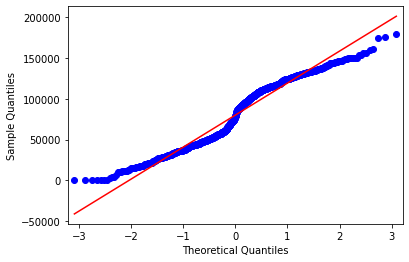

In [ ]:
check_income.QQ_plot()

In [ ]:
check_income.Shapiro_Wilk()

Kết quả kiểm định Shapiro-Wilk: stat=0.9524417519569397, p=1.8453352255402555e-17
Phủ định H0, phân bố không phải Gaussian


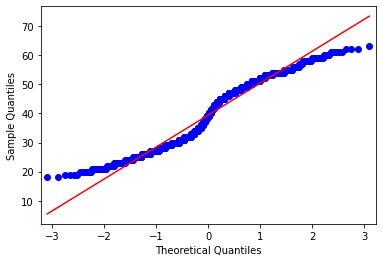

In [ ]:
check_age.QQ_plot()

In [ ]:
check_age.Shapiro_Wilk()

Kết quả kiểm định Shapiro-Wilk: stat=0.9490379691123962, p=4.217338994070984e-18
Phủ định H0, phân bố không phải Gaussian


In [ ]:
def draw_box(data: pd.DataFrame, 
             x:str, 
             grp: str):
    
    df = data.copy()
    df[grp] = df[grp].map(g_labs)
    
    plt.rcParams["figure.figsize"] = (8,3)
    plt.rcParams.update({'font.size': 12})
    
    sns.boxplot(data = df, 
                x = x,
                y = grp,
                hue = grp,
                showfliers = True,
                palette = bin_pals)
    
    plt.xlabel(trans_dict[x])
    plt.ylabel("Nhóm khách hàng")
    plt.legend(loc = 'center right')
    
    plt.show()

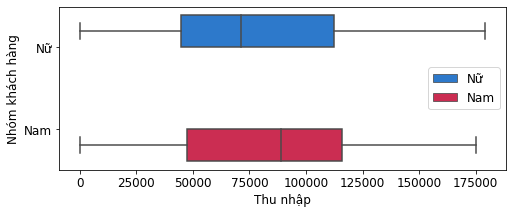

In [ ]:
draw_box(df, x='income', grp = 'gender')

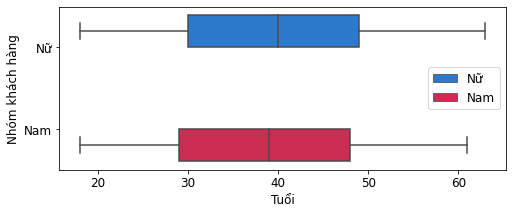

In [ ]:
draw_box(df, x='age', grp='gender')

In [ ]:
def multiple_kde(data: pd.DataFrame,
                 feats: list,
                 grp: str):
    
    plt.rcParams["figure.figsize"] = (12,8)
    plt.rcParams.update({'font.size': 12})
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.subplots_adjust(hspace=0.5)
    
    fig.suptitle(f'Đặc tính phân bố của {len(feats)} biến')
    
    for ax,feature in zip(axes.flatten(), feats):
        
        lim = data[feature].min(), data[feature].max()
        
        for k,c in zip(data[grp].unique(),bin_pals):
            df = data[data[grp] == k][[feature]]
            
            sns.kdeplot(data = df[feature],
                    shade = True,
                    color = c,
                    clip = lim,
                    alpha = 0.3,
                    label = g_labs[k],
                    ax = ax)
        
            sns.rugplot(data = df[feature],
                        color = c, 
                        alpha = 0.4,
                        ax = ax)
            
        ax.set_xlabel(trans_dict[feature])
        
    axes.flatten()[1].legend(loc='center', bbox_to_anchor=(0.5,1.25), ncol=2)
    
    plt.tight_layout()
    plt.show()

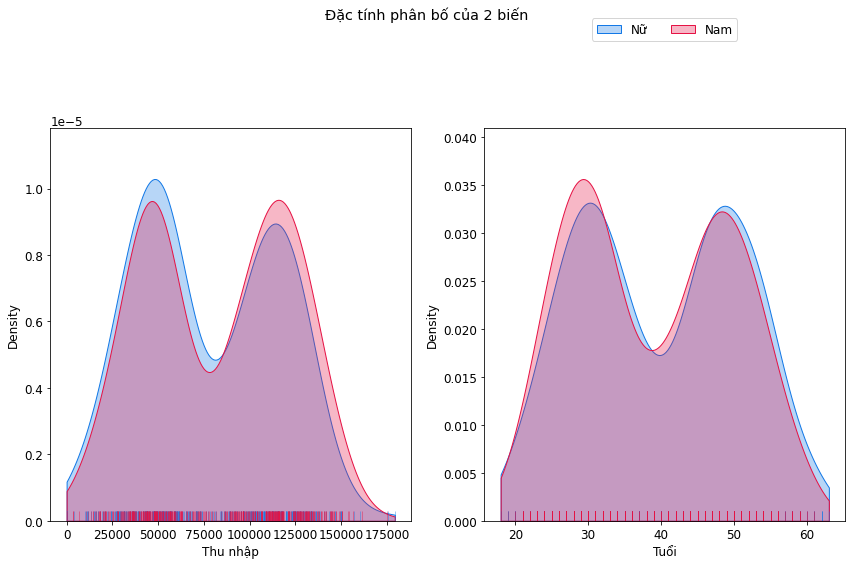

In [ ]:
multiple_kde(df, feats = num_vars, grp = 'gender')

In [ ]:
df = pd.get_dummies(df, drop_first=True) 
df.head()

,income,age,gender_Male
0,101743,58,0
1,49597,27,0
2,36517,52,1
3,33223,49,1
4,72994,53,0


In [ ]:
mmScaler = MinMaxScaler()
mmScaler.fit(df[['income', 
                 'age']])
data_sub = mmScaler.transform(df[['income', 
                                  'age']])

data_sub_mmScaler = pd.DataFrame(data_sub, 
                                 columns=['mm_income', 
                                          'mm_age'])
data = pd.concat([df.reset_index(drop=True), 
                  data_sub_mmScaler], axis=1)
data.head()

,income,age,gender_Male,mm_income,mm_age
0,101743,58,0,0.567465,0.888889
1,49597,27,0,0.276624,0.200000
2,36517,52,1,0.203671,0.755556
3,33223,49,1,0.185299,0.688889
4,72994,53,0,0.407119,0.777778


In [ ]:
#Chọn k
distortions = []
K = range(1,8)
for k in K:
  kmeanModel = KMeans(n_clusters=k) #số cụm
  kmeanModel.fit(data[['mm_income','mm_age']])
  distortions.append(sum(np.min(cdist(data[['mm_income','mm_age']], 
                                      kmeanModel.cluster_centers_, 'euclidean'), axis=1))/ data[['mm_income','mm_age']].shape[0])


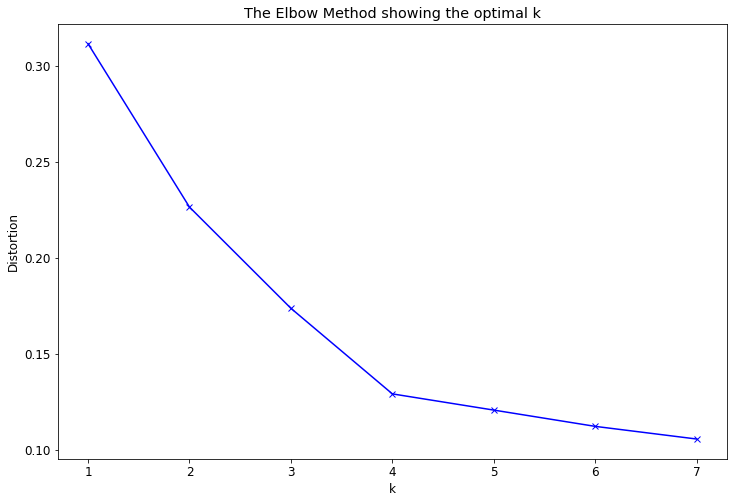

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title("The Elbow Method showing the optimal k")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data[['mm_income', 'mm_age']])


KMeans(n_clusters=4)

In [ ]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print("Centroids in min-max scale:")
print(centroids) 
print("Centroids in normal:")
normal_centroids = mmScaler.inverse_transform(centroids)
print(normal_centroids)
print(labels)

Centroids in min-max scale:
[[0.24372937 0.25833333]
 [0.25925224 0.69644097]
 [0.64809667 0.6977591 ]
 [0.64257984 0.26106804]]
Centroids in normal:
[[ 43699.21370968     29.625     ]
 [ 46482.37109375     49.33984375]
 [116199.84453782     49.39915966]
 [115210.70930233     29.74806202]]
[2 0 1 1 1 0 0 3 0 1 0 0 0 2 2 1 3 3 0 1 0 3 2 2 0 3 2 0 2 3 0 0 0 3 3 3 0
 0 1 2 1 1 2 3 3 3 2 2 3 0 3 1 2 0 1 0 0 0 3 0 2 1 3 3 0 3 1 3 2 3 1 3 3 2
 1 1 0 3 3 2 2 0 3 1 3 1 1 1 1 3 1 0 1 3 0 0 3 1 1 1 0 3 1 2 1 0 3 1 1 1 0
 2 2 0 3 1 2 3 0 1 2 0 3 0 1 0 3 0 0 2 3 0 1 3 2 1 3 0 2 0 1 0 1 3 0 1 2 3
 3 0 3 0 3 1 0 0 3 0 3 2 2 3 2 3 2 0 0 2 3 0 3 1 3 2 1 1 2 2 3 3 1 0 3 0 2
 3 3 2 2 3 3 1 0 0 0 0 2 3 2 1 2 1 1 0 1 2 2 1 1 1 1 1 2 2 1 0 3 0 2 1 3 3
 0 3 3 2 1 0 1 2 2 1 2 3 0 3 0 2 0 2 2 1 0 3 1 2 2 0 0 3 0 0 0 1 1 1 3 3 2
 3 3 0 2 3 0 2 2 0 3 1 1 3 0 2 2 2 0 0 2 2 2 3 0 2 3 2 1 0 1 0 0 1 2 3 0 3
 1 3 2 0 3 1 3 2 0 1 1 3 0 1 3 3 1 1 1 0 3 0 2 1 1 0 2 1 1 0 2 1 1 1 1 0 3
 3 1 0 0 0 2 2 0 3 3 1 1 0 2 0 1 0

In [ ]:
data['Group'] = pd.Series(labels)
data.head()

,income,age,gender_Male,mm_income,mm_age,Group
0,101743,58,0,0.567465,0.888889,2
1,49597,27,0,0.276624,0.200000,0
2,36517,52,1,0.203671,0.755556,1
3,33223,49,1,0.185299,0.688889,1
4,72994,53,0,0.407119,0.777778,1


In [ ]:
data.Group.value_counts()

3    258
1    256
0    248
2    238
Name: Group, dtype: int64

In [ ]:
i = 0
for cluster in normal_centroids:
  print("*** Centroid Cluster:" + str(i))
  print("Income:", round(cluster[0],2))
  print("Age:", round(cluster[1]), 2)

  i = i +1

*** Centroid Cluster:0
Income: 43699.21
Age: 30 2
*** Centroid Cluster:1
Income: 46482.37
Age: 49 2
*** Centroid Cluster:2
Income: 116199.84
Age: 49 2
*** Centroid Cluster:3
Income: 115210.71
Age: 30 2


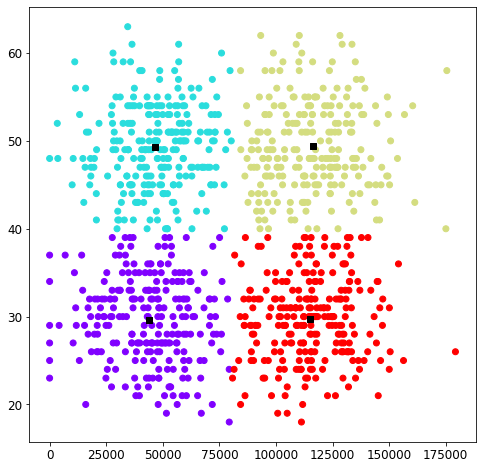

In [ ]:
plt.figure(figsize=(8,8))

plt.scatter(data.income, data.age, c=data.Group, cmap='rainbow')
plt.scatter(normal_centroids[:,0], normal_centroids[:,1], marker = 's', c = 'black')
plt.show()